In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, glob, os, warnings
from cv2 import blur as box_filter

warnings.filterwarnings("ignore")

In [7]:
gt_path = r".\Dataset\I-HAZE\I-HAZY NTIRE 2018\GT/02_indoor_GT.jpg"
hazy_img_path = r".\Dataset\I-HAZE\I-HAZY NTIRE 2018\hazy/02_indoor_hazy.jpg"

In [ ]:
# #### Dark Channel

In [15]:
patch_size = 15


def plot(img, title, cmap=''):
    if (len(cmap) != 0):
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.title(title)
    plt.show()


def get_min_value_patch_channel(img, rows, columns, patch_size):
    min_channel, border = np.zeros((rows, columns)), patch_size // 2
    for row in range(rows):
        for col in range(columns):
            min_channel[row - border][col - border] = np.min(img[row, col, :])
    return min_channel


def get_min_value_patch_whole(img, channel, rows, columns, patch_size):
    dark_channel, border = np.zeros((img.shape[0], img.shape[1])), patch_size // 2
    for row in range(border, rows - border):
        for col in range(border, columns - border):
            dark_channel[row - border][col - border] = np.min(
                channel[row - border:row + border, col - border:col + border])
    return dark_channel


def calculate_dark_channel_image(img, patch_size):
    dark_channel, border = np.zeros((img.shape[0], img.shape[1])), patch_size // 2
    img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    no_rows, no_cols = img.shape[0], img.shape[1]

    # min pixel value in patch among channel-wise
    min_channel = get_min_value_patch_channel(img, no_rows, no_cols, patch_size)
    # min pixel value in patch after min_channel
    dark_channel = get_min_value_patch_whole(dark_channel, min_channel, no_rows, no_cols, patch_size)
    return dark_channel

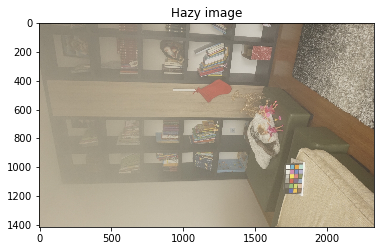

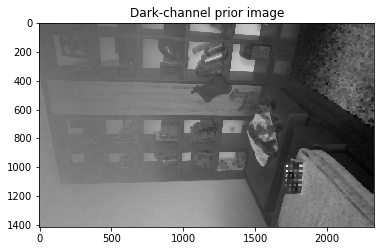

In [16]:
hazy_img = cv2.imread(hazy_img_path)
hazy_img = cv2.resize(hazy_img, (0, 0), fx=0.5, fy=0.5)
plot(hazy_img[:, :, ::-1], 'Hazy image')

dark_channel_img = calculate_dark_channel_image(hazy_img, patch_size).astype('uint8')
plot(dark_channel_img, 'Dark-channel prior image', cmap='gray')

In [17]:
# ### atmospheric light - A

In [18]:
def atmospheric_light_A(h_img, dark_img):
    print('size:', dark_img.shape)
    img = h_img.copy()
    total_pixels = dark_img.size
    print('# pixels:', total_pixels)
    bright_pixels_count = total_pixels // 1000  # 0.1% from paper
    print('# bright pixels:', bright_pixels_count)
    # getting indices of brightest pixels in the deep-channel image and Indices sorted based on corresponding pixel values in Descending order
    sorted_indices_of_bright_pixels = np.argsort(dark_img, axis=None)[::-1]
    # top 0.1% =3296
    sorted_indices_of_bright_pixels = np.unravel_index(sorted_indices_of_bright_pixels[0:bright_pixels_count],
                                                       dark_img.shape)
    print('Top 0.1% pixel indices:', sorted_indices_of_bright_pixels)
    bright_pixels = img[sorted_indices_of_bright_pixels]  # selecting the pixels in hazy images
    # (index of max(channel-wise avg))
    A = bright_pixels[np.argmax(np.average(bright_pixels, axis=1))]  # A = global atmospheric light
    return A

size: (1416, 2328)
# pixels: 3296448
# bright pixels: 3296
Top 0.1% pixel indices: (array([993, 993, 994, ...,  67,  67, 310], dtype=int64), array([1726, 1725, 1725, ..., 1467, 1468, 1387], dtype=int64))


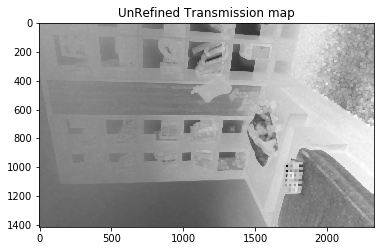

In [20]:
A = atmospheric_light_A(hazy_img, dark_channel_img)

OMEGA = 0.85  # min haze factor
unrefined_transmission_map = 1 - (OMEGA * calculate_dark_channel_image(hazy_img / A, patch_size))
plot(unrefined_transmission_map, 'UnRefined Transmission map', cmap='gray')

### Dehazed Image

In [21]:
def final_Dehazed_image(h_img, transmissionMap, A, t0):
    temp = np.copy(transmissionMap)
    temp[temp < t0] = t0  # clipping the values --> max(t1, t0)
    dehazed_img = np.zeros((h_img.shape))  # reconstruction img from formula
    channels = 3
    for ch in range(channels):
        dehazed_img[:, :, ch] = ((h_img[:, :, ch] - A[ch]) / temp) + A[ch]
    return dehazed_img

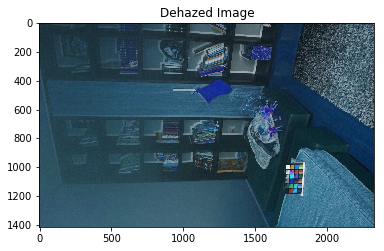

In [22]:
haz_img = hazy_img.astype("double")
finalImage = final_Dehazed_image(haz_img, unrefined_transmission_map, A, 0.1)
finalImage = ((finalImage - np.min(finalImage)) / (np.max(finalImage) - np.min(finalImage))) * 255

plot(np.uint8(finalImage), 'Dehazed Image')

### comparison

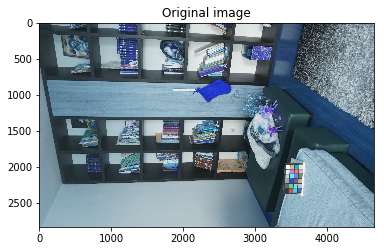

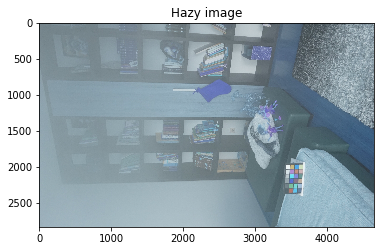

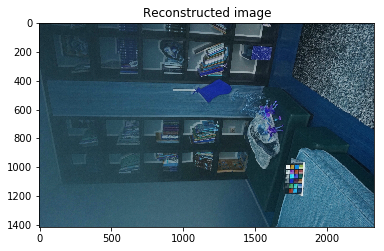

In [23]:
original_img = cv2.imread(gt_path)
plt.imshow(original_img)
plt.title('Original image')
plt.show()

original_hazy_img = cv2.imread(hazy_img_path)
plt.imshow(original_hazy_img)
plt.title('Hazy image')
plt.show()

plt.imshow((np.uint8(finalImage)))
plt.title('Reconstructed image')
plt.show()

# In[ ]: